In [25]:

import yaml
from pathlib import Path

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import joblib

from clearml import Task

In [16]:
task = Task.init(
    project_name="MLOps IMDB Sentiment",
    task_name="tfidf_logreg_and_linear_svc",
    task_type=Task.TaskTypes.training,
)
logger = task.get_logger()

ClearML Task: created new task id=56d9f1f35c1c41a88036ad82558af620
ClearML results page: https://app.clear.ml/projects/1df5f41282ec4f7a8bbf2b6c322e0a53/experiments/56d9f1f35c1c41a88036ad82558af620/output/log


ClearML Monitor: GPU monitoring failed getting GPU reading, switching off GPU monitoring
ClearML Monitor: Could not detect iteration reporting, falling back to iterations as seconds-from-start
ClearML Monitor: Reporting detected, reverting back to iteration based reporting


In [17]:
CFG_PATH = Path("..") / "configs" / "config.yaml"
with open(CFG_PATH, "r") as f:
    full_cfg = yaml.safe_load(f)

train_cfg = full_cfg["train"]

run_cfg = dict(train_cfg)
run_cfg["preprocessing_version"] = "tfidf_v1_and_linear_svc"

task.connect(run_cfg)
task.upload_artifact(name="config_yaml", artifact_object=str(CFG_PATH))

True

In [18]:
DATA_PATH = Path("..") / train_cfg["data"]["path"]

df = pd.read_csv(DATA_PATH)
df["sentiment"] = df["sentiment"].map({"negative": 0, "positive": 1})

X = df["review"]
y = df["sentiment"]

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=train_cfg["test_size"],
    random_state=train_cfg["random_state"],
    stratify=y,
)

print("Train size:", X_train.shape[0])
print("Test size:", X_test.shape[0])

Train size: 40000
Test size: 10000


In [19]:
vectorizer = TfidfVectorizer(
    max_features=train_cfg["vectorizer"]["max_features"],
    ngram_range=tuple(train_cfg["vectorizer"]["ngram_range"]),
    stop_words=train_cfg["vectorizer"]["stop_words"],
)

X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

print("TF-IDF shape:", X_train_tfidf.shape)

TF-IDF shape: (40000, 5000)


sentiment
1    0.5
0    0.5
Name: proportion, dtype: float64


/Users/vohmin.ae/Desktop/mlops_movie_sentiment/.venv/lib/python3.9/site-packages/clearml/utilities/plotlympl/renderer.py:209: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



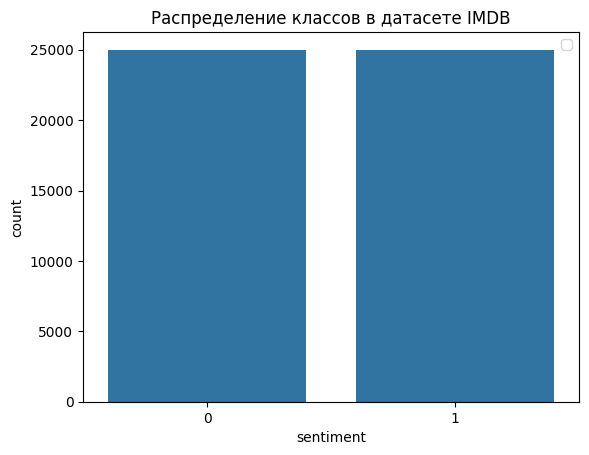

In [20]:
print(df["sentiment"].value_counts(normalize=True))

sns.countplot(data=df, x="sentiment")
plt.title("Распределение классов в датасете IMDB")
plt.show()

In [21]:
logreg = LogisticRegression(
    max_iter=train_cfg["model"]["max_iter"],
    n_jobs=train_cfg["model"]["n_jobs"],
    random_state=train_cfg["random_state"],
)

logreg.fit(X_train_tfidf, y_train)

y_pred_logreg = logreg.predict(X_test_tfidf)
acc_logreg = accuracy_score(y_test, y_pred_logreg)

report_logreg = classification_report(y_test, y_pred_logreg)
cm_logreg = confusion_matrix(y_test, y_pred_logreg)

print("LogReg accuracy:", acc_logreg)
print(report_logreg)

logger.report_scalar("accuracy", "logreg_tfidf", acc_logreg, iteration=0)
logger.report_text("classification_report", "logreg_tfidf", report_logreg, iteration=0)

logger.report_confusion_matrix(
    title="Confusion Matrix - LogisticRegression",
    series="logreg_tfidf",
    matrix=cm_logreg,
    iteration=0,
    xlabels=["negative", "positive"],
    ylabels=["negative", "positive"],
)

Logger failed casting log level "logreg_tfidf" to integer


LogReg accuracy: 0.891
              precision    recall  f1-score   support

           0       0.90      0.88      0.89      5000
           1       0.88      0.90      0.89      5000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000

classification_report


In [ ]:
MODELS_DIR = Path("..") / "models"
MODELS_DIR.mkdir(exist_ok=True)

logreg_path = MODELS_DIR / "logreg_imdb.joblib"
tfidf_path = MODELS_DIR / "tfidf_imdb.joblib"

joblib.dump(logreg, logreg_path)
joblib.dump(vectorizer, tfidf_path)

task.upload_artifact("logreg_model", artifact_object=str(logreg_path))
task.upload_artifact("tfidf_vectorizer", artifact_object=str(tfidf_path))

True

In [23]:
svc = LinearSVC(random_state=train_cfg["random_state"])
svc.fit(X_train_tfidf, y_train)

y_pred_svc = svc.predict(X_test_tfidf)
acc_svc = accuracy_score(y_test, y_pred_svc)

report_svc = classification_report(y_test, y_pred_svc)
cm_svc = confusion_matrix(y_test, y_pred_svc)

print("LinearSVC accuracy:", acc_svc)
print(report_svc)

logger.report_scalar("accuracy", "linear_svc_tfidf", acc_svc, iteration=0)
logger.report_text("classification_report", "linear_svc_tfidf", report_svc, iteration=0)

logger.report_confusion_matrix(
    title="Confusion Matrix - LinearSVC",
    series="linear_svc_tfidf",
    matrix=cm_svc,
    iteration=0,
    xlabels=["negative", "positive"],
    ylabels=["negative", "positive"],
)

Logger failed casting log level "linear_svc_tfidf" to integer


LinearSVC accuracy: 0.8819
              precision    recall  f1-score   support

           0       0.89      0.88      0.88      5000
           1       0.88      0.89      0.88      5000

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000

classification_report


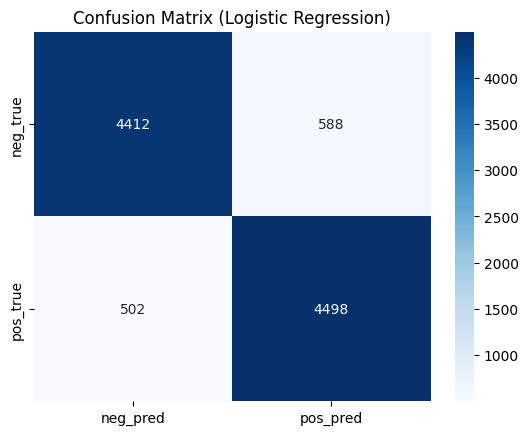

In [ ]:
cm = confusion_matrix(y_test, y_pred_logreg, labels=[0, 1])

cm_df = pd.DataFrame(
    cm,
    index=["neg_true", "pos_true"],
    columns=["neg_pred", "pos_pred"],
)

sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix (Logistic Regression)")
plt.show()

logger.report_confusion_matrix(
    title="confusion_matrix",
    series="logreg_tfidf",
    matrix=cm,
    iteration=0,
    xlabels=["negative", "positive"],
    ylabels=["negative", "positive"],
)

In [ ]:
task.close()